## Setup

In [1]:
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


Initially this returns a dataset of (text, label pairs):

In [3]:
df = pd.read_csv('https://www.dropbox.com/scl/fi/gjl0z298kxs3n78e1mj9l/training_data_companydata_adjusted_by_keywords.csv?rlkey=gfexpgeo6hrybtn9un2r2t399&dl=1')
df = df.groupby('text').max().reset_index()

print('10 random samples:')
display(df.sample(10))

stakeholder = 'SOC'
df['label'] = df[stakeholder]
df = df[['text', 'label']].groupby('text').max().reset_index()

print('labels:')
print(df['label'].value_counts())

10 random samples:


,text,performance,CUS,INV,EMP,SOC
1994,During periods in which price competition is h...,0,0,0,0,0
2465,Guarantees related to the majority of withdraw...,1,0,1,0,0
6131,"We may need to modify our business, strategies...",0,0,0,0,0
728,"Additionally, liquidity in JPMorgan Chase Bank...",0,0,0,0,0
2505,"However, because dividend tests may be based o...",0,0,0,0,0
6326,"as a result of these actions, the Company rec...",1,0,1,0,0
1683,Compensation and benefits expenses increased a...,1,0,0,1,0
6526,the date on which a Change in Control occurs; ...,0,0,0,0,0
2303,"For the treaty effective in July 2018, the agg...",0,0,0,0,0
2529,"However, recent hedging activity has reduced t...",0,0,0,0,0


labels:
0    6500
1      64
Name: label, dtype: int64


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [5]:
!mkdir knowledge_data
!mkdir knowledge_data/neg
!mkdir knowledge_data/pos

mkdir: cannot create directory ‘knowledge_data’: File exists
mkdir: cannot create directory ‘knowledge_data/neg’: File exists
mkdir: cannot create directory ‘knowledge_data/pos’: File exists


In [6]:
for i in df[df['label']==0].index:
  txt = df.iloc[i]['text']
  text_file = open(f"knowledge_data/neg/{i}.txt", "wt")
  text_file.write(txt)
  text_file.close()
for i in df[df['label']==1].index:
  txt = df.iloc[i]['text']
  text_file = open(f"knowledge_data/pos/{i}.txt", "wt")
  text_file.write(txt)
  text_file.close()

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'knowledge_data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_dataset = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.keras.utils.text_dataset_from_directory(
    'knowledge_data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 6564 files belonging to 2 classes.
Using 5252 files for training.
Found 6564 files belonging to 2 classes.
Using 1312 files for validation.


In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Sales results may fluctuate significantly due to case size and timing of sales submissions.'
 b'For purposes of the Plan, "Termination for Cause" means the continued failure of the Eligible Employee to perform substantially the Eligible Employees duties with the Employer  (other than any such failure resulting from incapacity due to physical or mental illness) , after a written demand for substantial performance is delivered to the Eligible Employee by the Chief Executive Officer of the Corporation which specifically identifies the manner in which the Chief Executive Officer believes that the Eligible Employee has not substantially performed the Eligible Employees duties, or the willful engaging by the Eligible Employee in illegal conduct or gross misconduct which is materially and demonstrably injurious to the Employer, or conviction of a felony or guilty or nolo contendere plea by the Eligible Employee with respect thereto.'
 b'For this table, changes that are not solely d

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'of', 'to', 'and', 'in', 'a', 'or', 'our',
       'as', 'due', 'for', 'are', 'that', 'may', 'we', 'result', 'on',
       'is'], dtype='<U15')

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[240,  73,  15, 753, 225,  11,   4, 639, 659,   5, 464,   3, 240,
          1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 12, 471,   3,   2, 158, 623,  12,  65,   1,   2, 391, 197,   3,
          2, 827, 256,   4, 716, 624,   2, 827, 265,   1,  24,   2,   1,
         25,  76,  45,  40, 197, 310,  20,   1,  11,   4,   1,   8,   1,
          1, 479,   7, 777, 532,  12, 483, 129,  19,   1,   4,   2, 82

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Sales results may fluctuate significantly due to case size and timing of sales submissions.'
Round-trip:  sales results may fluctuate significantly due to case size and timing of sales [UNK]                                                                                                                

Original:  b'For purposes of the Plan, "Termination for Cause" means the continued failure of the Eligible Employee to perform substantially the Eligible Employees duties with the Employer  (other than any such failure resulting from incapacity due to physical or mental illness) , after a written demand for substantial performance is delivered to the Eligible Employee by the Chief Executive Officer of the Corporation which specifically identifies the manner in which the Chief Executive Officer believes that the Eligible Employee has not substantially performed the Eligible Employees duties, or the willful engaging by the Eligible Employee in illegal conduct or gross miscondu

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

The code to implement this is below:

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [15]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

accuracy = tf.metrics.BinaryAccuracy()
recall = tf.metrics.Recall()
precision = tf.metrics.Precision()
metrics = [accuracy, recall, precision]

In [16]:
model.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=metrics)

## Train the model

In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
165/165 [==============================] - 35s 128ms/step - loss: 0.3368 - binary_accuracy: 0.9901 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0470 - val_binary_accuracy: 0.9937 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
165/165 [==============================] - 3s 18ms/step - loss: 0.0672 - binary_accuracy: 0.9901 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0589 - val_binary_accuracy: 0.9906 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
165/165 [==============================] - 4s 25ms/step - loss: 0.0608 - binary_accuracy: 0.9901 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0511 - val_binary_accuracy: 0.9917 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
165/165 [==============================] - 3s 18ms/step - loss: 0.0585 - binary_accuracy: 0.9901 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0554 - val_binary_accuracy: 0.9906 - val_recall: 0.0000e+00 - val_

In [18]:
loss, accuracy, recall, precision = model.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1: {0 if (recall + precision)==0 else 2 * recall * precision / (recall + precision)}')

41/41 [==============================] - 0s 10ms/step - loss: 0.0519 - binary_accuracy: 0.9909 - recall: 0.0000e+00 - precision: 0.0000e+00
Loss: 0.05186646804213524
Accuracy: 0.9908536672592163
Recall: 0.0
Precision: 0.0
F1: 0


In [19]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'recall', 'precision', 'val_loss', 'val_binary_accuracy', 'val_recall', 'val_precision'])


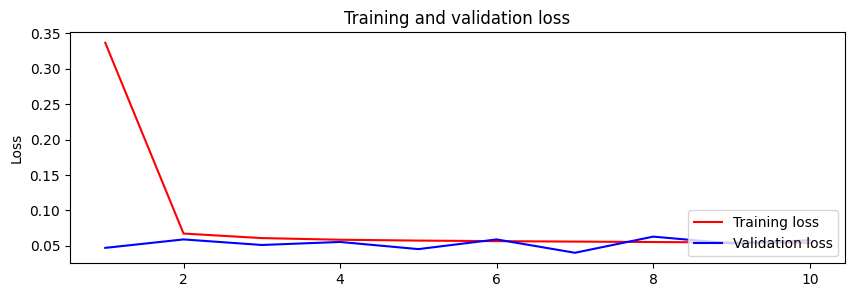

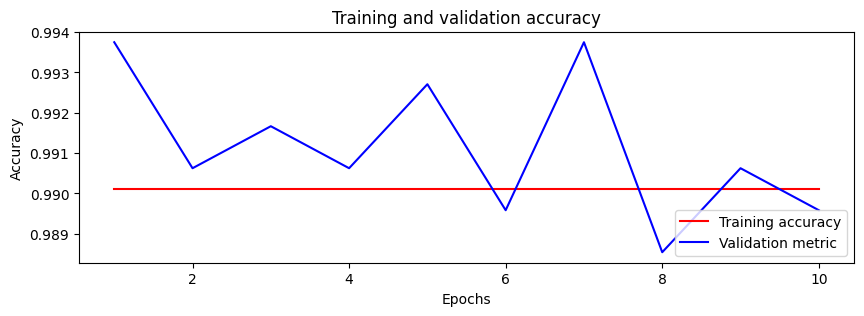

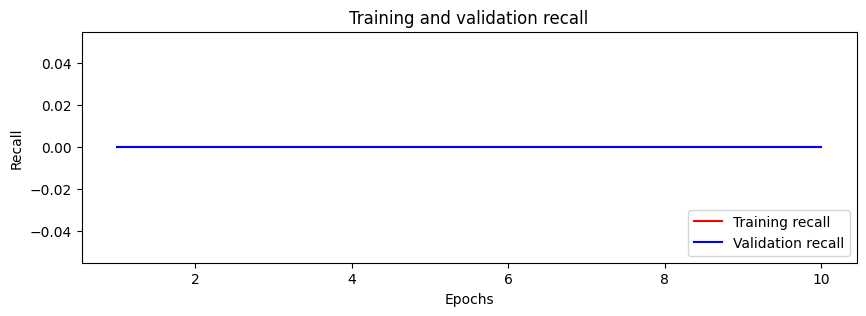

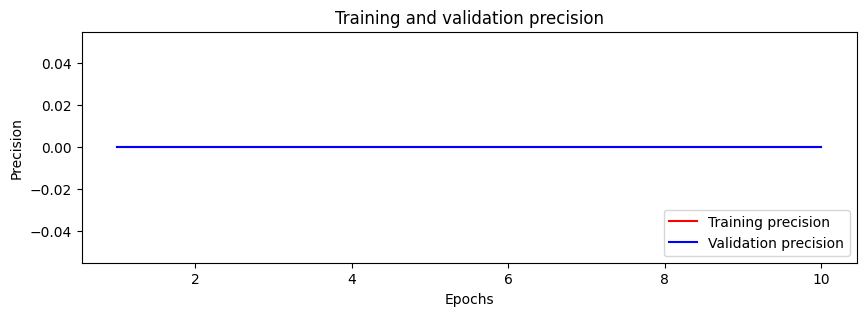

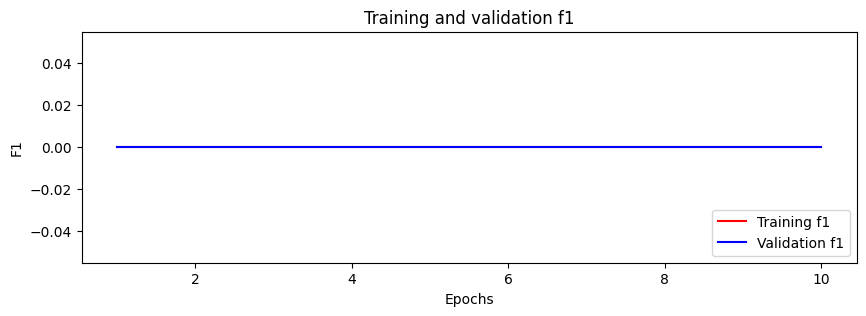

In [20]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

accuracy = history_dict['binary_accuracy']
val_accuracy = history_dict['val_binary_accuracy']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

precision = history_dict['precision']
val_precision = history_dict['val_precision']

f1 = [0 if i+j ==0 else 2 * i * j / (i + j) if (i + j) > 0 else None for i,j in zip(recall, precision) ]
val_f1 = [0 if i+j==0 else 2 * i * j / (i + j) if (i + j) > 0 else None for i,j in zip(val_recall, val_precision)]

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation metric')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, f1, 'r', label='Training f1')
plt.plot(epochs, val_f1, 'b', label='Validation f1')
plt.title('Training and validation f1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend(loc='lower right')
plt.show()
plt.close()

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [21]:
sample_text = ('Bank of America hit with $250M in fines and refunds for double-dipping fees and fake accounts.')
predictions = model.predict(np.array([sample_text]))
predictions

1/1 [==============================] - 3s 3s/step


array([[-4.9661555]], dtype=float32)

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=metrics)

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
165/165 [==============================] - 41s 129ms/step - loss: 0.3379 - binary_accuracy: 0.9902 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0692 - val_binary_accuracy: 0.9885 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
165/165 [==============================] - 6s 38ms/step - loss: 0.0697 - binary_accuracy: 0.9901 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0669 - val_binary_accuracy: 0.9885 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
165/165 [==============================] - 5s 31ms/step - loss: 0.0662 - binary_accuracy: 0.9901 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0653 - val_binary_accuracy: 0.9885 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
165/165 [==============================] - 6s 38ms/step - loss: 0.0659 - binary_accuracy: 0.9901 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0646 - val_binary_accuracy: 0.9885 - val_recall: 0.0000e+00 - val_

In [25]:
loss, accuracy, recall, precision = model.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1: {0 if (recall + precision)==0 else 2 * recall * precision / (recall + precision)}')

41/41 [==============================] - 1s 12ms/step - loss: 0.0516 - binary_accuracy: 0.9909 - recall: 0.0000e+00 - precision: 0.0000e+00
Loss: 0.05160157382488251
Accuracy: 0.9908536672592163
Recall: 0.0
Precision: 0.0
F1: 0


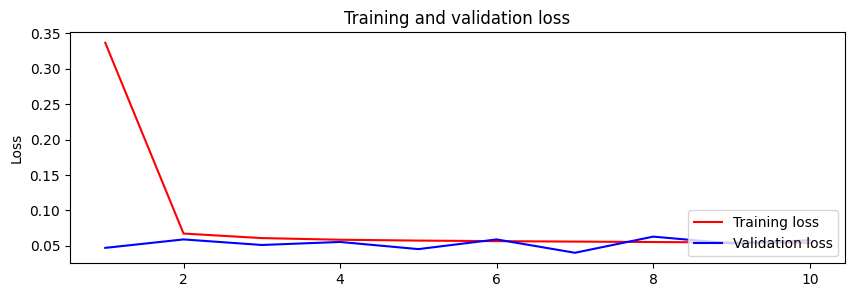

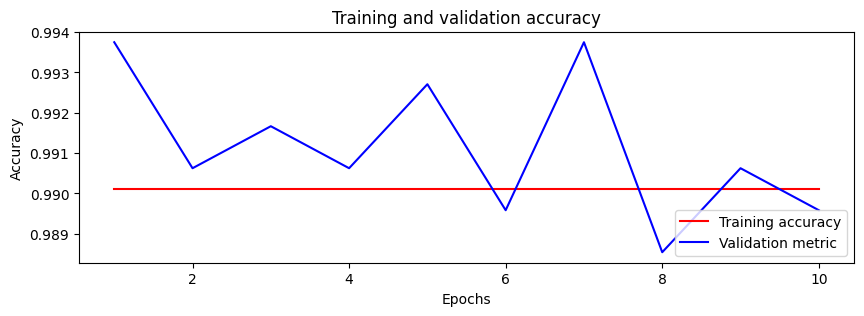

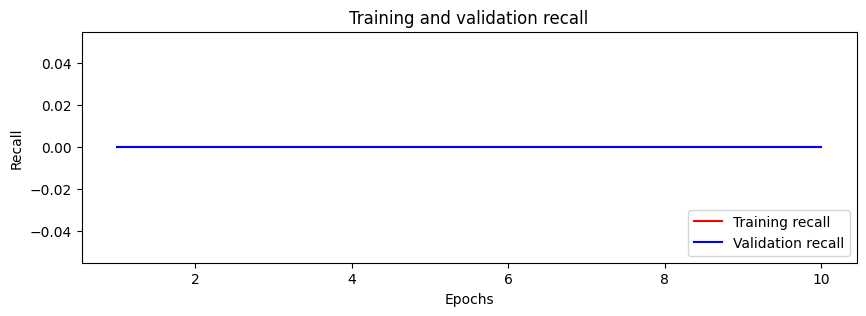

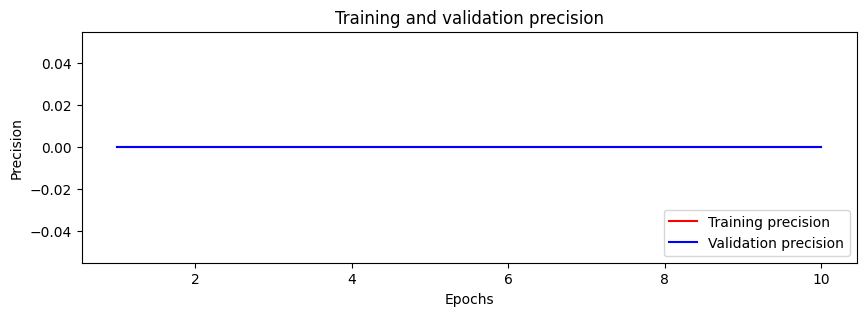

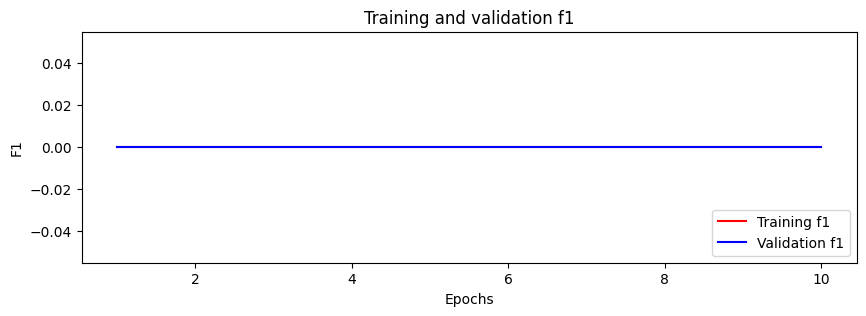

In [26]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

accuracy = history_dict['binary_accuracy']
val_accuracy = history_dict['val_binary_accuracy']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

precision = history_dict['precision']
val_precision = history_dict['val_precision']

f1 = [0 if i+j==0 else 2 * i * j / (i + j) if (i + j) > 0 else None for i,j in zip(recall, precision) ]
val_f1 = [0 if i+j==0 else 2 * i * j / (i + j) if (i + j) > 0 else None for i,j in zip(val_recall, val_precision)]

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation metric')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, f1, 'r', label='Training f1')
plt.plot(epochs, val_f1, 'b', label='Validation f1')
plt.title('Training and validation f1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend(loc='lower right')
plt.show()
plt.close()